# Projet 8 - Réalisez un dashboard et assurez une veille technique

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import LabelEncoder
from sklearn import cluster, metrics

import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, adjusted_rand_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from PIL import Image, ImageOps, ImageFilter
from IPython.display import Image, display

# Enoncé

Vous êtes Data Scientist au sein d'une société financière nommée Prêt à dépenser, qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt. Vous venez de mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, et classifier la demande en crédit accordé ou refusé. Après avoir bien avancé dans la réalisation du dashboard, Michaël décide de vous confier une autre mission.


# Missions

Pourrais-tu réaliser un état de l’art sur une technique récente de modélisation de données texte ou de données image, l’analyser, la tester et la comparer à une approche plus classique que tu as réalisée précédemment ? Concrètement, voici ce que j’attends de ta part :

- L’état de l’art devra concerner une technique datant de moins de 5 ans, présentée dans un article.
- La technique doit être référencée sur des sites de recherche (Arxiv), des sites connus (par exemple fastml, machine learning mastery, kdnuggets, import AI, MIT tech review, MIT news ML) ou des newsletters de qualité comme data elixir et data science weekly.
- Tu réaliseras et nous présenteras une preuve de concept qui met en oeuvre cette nouvelle technique avec les données texte ou image que tu as déjà exploitées précédemment.
- Tu nous expliqueras rapidement les concepts et techniques dans une note méthodologique (modèle en pièce-jointe) et lors d’une présentation.

# Approche choisie

Nous reprenons le précedent projet "Classifiez automatiquement des biens de consommation" afin de réaliser cette mission. 
L'état de l'art sera réalisée sur une technique nommée CLIP (Contrastive Language-Image Pre-Training). 

Cette approche sera comparé à l'approche sélectionné lors du projet 6, à savoir l'approche par Dataset avec data augmentation intégrée au modèle

## I- Visualisation des données

In [120]:
df = pd.read_csv("C:/Users/Anais/Documents/Projet8-/Dataset+projet+prétraitement+textes+images/Flipkart/path_image_cleaned.csv")
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
df.head()

,image,main_category,path_image,processed_images
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing,Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg,Images_processed\55b85ea15a1536d46b7190ad6fff8...
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care,Images/7b72c92c2f6c40268628ec5f14c6d590.jpg,Images_processed\7b72c92c2f6c40268628ec5f14c6d...
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care,Images/64d5d4a258243731dc7bbb1eef49ad74.jpg,Images_processed\64d5d4a258243731dc7bbb1eef49a...
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing,Images/d4684dcdc759dd9cdf41504698d737d8.jpg,Images_processed\d4684dcdc759dd9cdf41504698d73...
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing,Images/6325b6870c54cd47be6ebfbffa620ec7.jpg,Images_processed\6325b6870c54cd47be6ebfbffa620...


In [121]:
print('Ce jeu de donnée comporte ' + str(df.shape[0]) + ' lignes et ' + str(df.shape[1]) + ' colonnes')
df.info()

Ce jeu de donnée comporte 1050 lignes et 4 colonnes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image             1050 non-null   object
 1   main_category     1050 non-null   object
 2   path_image        1050 non-null   object
 3   processed_images  1050 non-null   object
dtypes: object(4)
memory usage: 32.9+ KB


## II- Nettoyage des données

On élimine les colonnes inutiles pour ce notebook

In [122]:
# Elimination des variables inutiles pour ce notebook
df = df.drop(["image", "processed_images"], axis= 1)
df.head()

,main_category,path_image
0,home furnishing,Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,baby care,Images/7b72c92c2f6c40268628ec5f14c6d590.jpg
2,baby care,Images/64d5d4a258243731dc7bbb1eef49ad74.jpg
3,home furnishing,Images/d4684dcdc759dd9cdf41504698d737d8.jpg
4,home furnishing,Images/6325b6870c54cd47be6ebfbffa620ec7.jpg


La variable 'main_category' doit être encodé

In [123]:
# Encodage de la catégorie
encoder= LabelEncoder()
df["class"] = encoder.fit_transform(df["main_category"])
df.head()

,main_category,path_image,class
0,home furnishing,Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg,4
1,baby care,Images/7b72c92c2f6c40268628ec5f14c6d590.jpg,0
2,baby care,Images/64d5d4a258243731dc7bbb1eef49ad74.jpg,0
3,home furnishing,Images/d4684dcdc759dd9cdf41504698d737d8.jpg,4
4,home furnishing,Images/6325b6870c54cd47be6ebfbffa620ec7.jpg,4


In [124]:
#Séparation du jeu de données
X = df.iloc[:,0:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=42)

data_ = np.concatenate((X_train, y_train.to_numpy().reshape(-1, 1)), axis=1)
data = pd.DataFrame(data_, columns=list(X.columns) + ['label'])
data_test_ = np.concatenate((X_test, y_test.to_numpy().reshape(-1, 1)), axis=1)
data_test = pd.DataFrame(data_test_, columns=list(X.columns) + ['label'])

#Visualisation du jeu de données
print(data.shape)
data.head(2)

(900, 3)


,main_category,path_image,label
0,watches,Images/c7207128c680a437e1cad834a8880007.jpg,6
1,beauty and personal care,Images/417ae3e8b08acc19a023b8a958644799.jpg,1


In [125]:
print(data_test.shape)
data_test.head(2)

(150, 3)


,main_category,path_image,label
0,computers,Images/833a87b0af3b84fe246d2ebf271af177.jpg,2
1,kitchen and dining,Images/55195de3873fffaa9e37b041533d7305.jpg,5


## III- Approche par Dataset avec data augmentation intégrée au modèle

Cette méthode combine les avantages de l'approche dataset traditionnelle avec ceux de l'augmentation de données en temps réel. Les données sont prétraitées comme dans l'approche dataset traditionnelle, mais au lieu de diviser les données en ensembles de formation, de validation et de test, les données d'entraînement sont augmentées en temps réel à l'aide de techniques telles que la rotation, le zoom, le décalage et la symétrie horizontale. Ces transformations sont appliquées de manière aléatoire à chaque image pendant l'entraînement, augmentant ainsi la quantité de données d'entraînement disponible et créant des variations des images originales.

Cette approche peut produire des performances similaires à celles de l'approche dataset traditionnelle avec l'augmentation de données appliquée séparément, mais nécessite moins de temps et d'efforts pour préparer les donnée.
s.les.

In [126]:
from tensorflow.keras.metrics import Precision, Recall

In [127]:
def create_model_fct2():
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1)
    ])

    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
        data_augmentation,
        Rescaling(1./127.5, offset=-1),
        model_base,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    
    # Build the model to fix the output shape issue
    model.build((None, 224, 224, 3))
    
    # Compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy", Precision(), Recall()])

    print(model.summary())

    return model

In [128]:
batch_size = 64

def data_flow_fct(data, datagen, data_type=None):
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                            x_col='path_image', y_col='main_category',
                                            target_size=(224, 224),
                                            class_mode='categorical',
                                            batch_size=batch_size, shuffle=True, seed=42,
                                            subset=data_type)
    return data_flow

In [129]:
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(X_train, datagen_train, data_type='training')
val_flow = data_flow_fct(X_train, datagen_train, data_type='validation')
test_flow = data_flow_fct(X_test, datagen_test, data_type=None)

Found 675 validated image filenames belonging to 7 classes.
Found 225 validated image filenames belonging to 7 classes.
Found 150 validated image filenames belonging to 7 classes.


La fonction `create_model_fct2` crée un modèle de réseau de neurones convolutifs pour la classification d'images en utilisant VGG16 comme base. Voici ce que fait la fonction :

- **Augmentation de données** : Elle modifie les images d'entrée avec des retournements, des rotations et des zooms aléatoires pour diversifier les données d'entraînement.
  
- **Modèle de base** : Elle charge le modèle VGG16 avec des poids pré-entraînés depuis "imagenet".
  
- **Nouveau modèle** : Elle assemble un nouveau modèle avec une couche de normalisation, VGG16, une couche de mise en commun, deux couches de neurones connectés, et une couche de sortie pour la classification.

- **Compilation du modèle** : Elle compile le modèle avec une fonction de perte, un optimiseur et des métriques pour l'entraînement.

Enfin, la fonction retourne le modèle prêt à être entraîné.


In [130]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct2()

# Création du callback
model_save_path = "./model_best_weights.h5.keras"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

D:\Programme\envs\projet8\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [131]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [132]:
with tf.device('/gpu:0'): 
    history4 = model4.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50


D:\Programme\envs\projet8\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1526 - loss: 2.0960 - precision: 0.0609 - recall: 0.0016  
Epoch 1: val_loss improved from inf to 1.53084, saving model to ./model_best_weights.h5.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 329s 18s/step - accuracy: 0.1573 - loss: 2.0847 - precision: 0.0670 - recall: 0.0017 - val_accuracy: 0.6444 - val_loss: 1.5308 - val_precision: 1.0000 - val_recall: 0.0178
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3703 - loss: 1.6681 - precision: 0.5130 - recall: 0.0289
Epoch 2: val_loss improved from 1.53084 to 1.22420, saving model to ./model_best_weights.h5.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 171s 15s/step - accuracy: 0.3742 - loss: 1.6627 - precision: 0.5423 - recall: 0.0321 - val_accuracy: 0.7600 - val_loss: 1.2242 - val_precision: 0.9737 - val_recall: 0.1644
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5194 - loss: 1.3977 - precision: 0.9470 - recall: 0.1460
Epoch 3: val_loss improved from 1.22420 to 1.03494, savi

In [133]:
# Score du dernier epoch
loss, accuracy, precision, recall = model4.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print("Training Precision  : {:.4f}".format(precision))
print("Training Recall     : {:.4f}".format(recall))
print()

loss, accuracy, precision, recall = model4.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation Precision: {:.4f}".format(precision))
print("Validation Recall   : {:.4f}".format(recall))

11/11 ━━━━━━━━━━━━━━━━━━━━ 122s 11s/step - accuracy: 0.8437 - loss: 0.5047 - precision: 0.9038 - recall: 0.7857
Training Accuracy   : 0.8444
Training Precision  : 0.9133
Training Recall     : 0.7807

4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 10s/step - accuracy: 0.8025 - loss: 0.6660 - precision: 0.8743 - recall: 0.7362
Validation Accuracy :  0.8044
Validation Precision: 0.8842
Validation Recall   : 0.7467


In [134]:
# Calcul du F1-score
f1 = 2 * (precision * recall) / (precision + recall)
print("Validation F1 Score : {:.4f}".format(f1))

Validation F1 Score : 0.8096


In [135]:
# Score de l'epoch optimal
model4.load_weights(model_save_path)

loss, accuracy, precision, recall = model4.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation Precision: {:.4f}".format(precision))
print("Validation Recall   : {:.4f}".format(recall))

f1 = 2 * (precision * recall) / (precision + recall)
print("Validation F1 Score : {:.4f}".format(f1))

loss, accuracy, precision, recall = model4.evaluate(test_flow, verbose=False)
print("Test Accuracy       : {:.4f}".format(accuracy))
print("Test Precision      : {:.4f}".format(precision))
print("Test Recall         : {:.4f}".format(recall))

f1 = 2 * (precision * recall) / (precision + recall)
print("Test F1 Score       : {:.4f}".format(f1))

Validation Accuracy :  0.8044
Validation Precision: 0.8763
Validation Recall   : 0.7244
Validation F1 Score : 0.7932
Test Accuracy       : 0.7467
Test Precision      : 0.8692
Test Recall         : 0.6200
Test F1 Score       : 0.7237


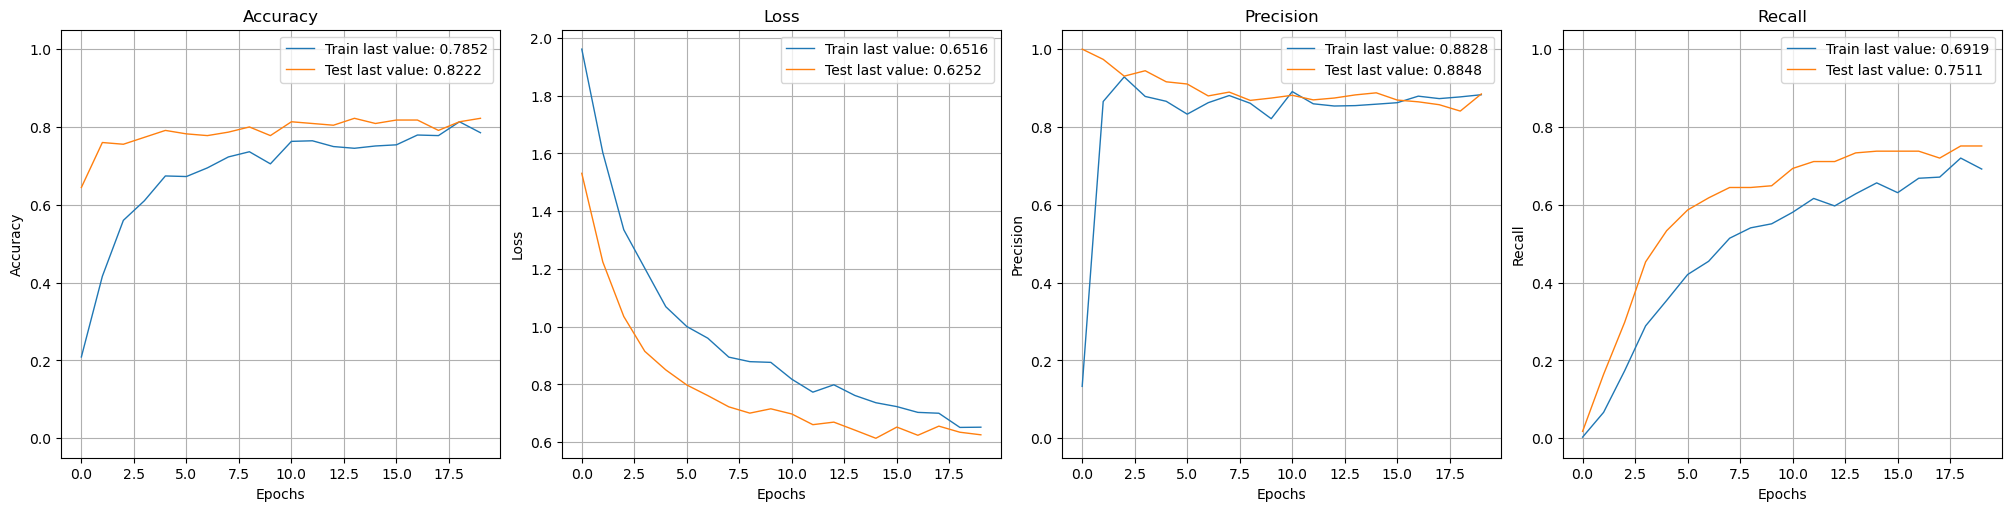

In [138]:
from plot_keras_history import show_history, plot_history

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

- Les résultats sont corrects au regard du nombre d’images
- La data augmentation permet surtout d’éviter le sur-apprentissage

## IV- CLIP (Contrastive Language-Image Pre-Training)

Le modèle CLIP (Contrastive Language-Image Pre-Training), développé par OpenAI, est conçu pour comprendre les relations entre le texte et les images. 
CLIP utilise une méthode de pré-entraînement contrastif, où il apprend à associer des paires (image, texte) en maximisant leur similarité. Le modèle est entraîné sur un large ensemble de données non étiquetées contenant des millions de paires d'images et de textes issus d'Internet. Le but est de créer des représentations vectorielles des images et des textes qui soient proches dans l'espace vectoriel si elles se correspondent (par exemple, une image de chien et le texte "un chien"), et éloignées sinon. La fonction de perte contrastive est utilisée pour optimiser ce processus, en rapprochant les vecteurs des paires correspondantes et en éloignant ceux des paires non correspondantes.

In [152]:
import torch
import clip
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

# Charger le modèle CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Pour réalisé une description textuelle de chaque catégorie, nous nous basons sur le wordcloud de chaque catégorie réalisé lors du projet 6 : 

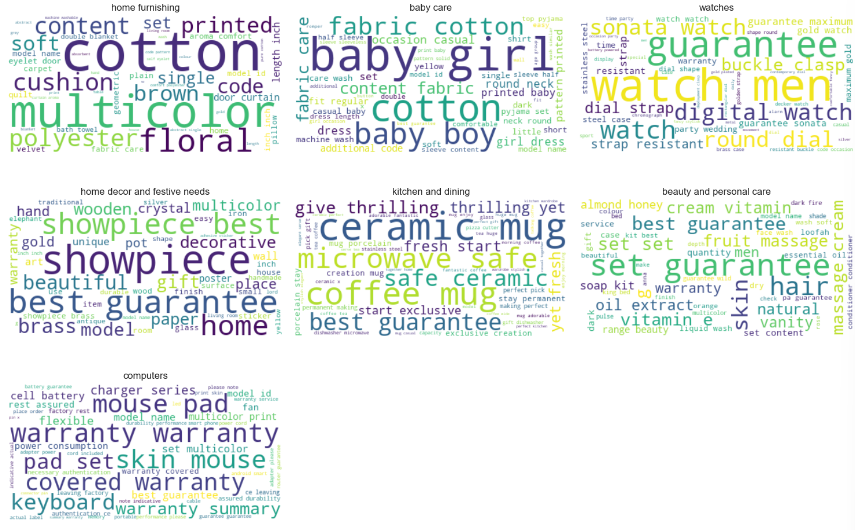

In [153]:
#Chemin vers le répertoire contenant toutes les images
data_path = "C:/Users/Anais/Documents/Projet8-/Dataset+projet+prétraitement+textes+images/Flipkart/"

# Images et leurs descriptions textuelles à utiliser
descriptions = {
    "baby care": "toys, clothes, and accessories for baby boys and girls",
    "beauty and personal care": "products for skin care, body care, and personal beauty routines",
    "computers": "computing devices, peripherals, and accessories for computer science",
    "home decor and festive needs": "decorative items and festive products for home decoration",
    "home furnishing": "furnishing products and decorative items for home interiors",
    "kitchen and dining": "kitchen tools, dining accessories, and mugs",
    "watches": "timepieces including wristwatches and other types of watches"
}

list_classes = list(descriptions.values())

Utilisation du CLIPProcessor sur les descriptions. Le résultat est un tensor de la taille de chacune des descriptions +2 pour les tokens début et fin.

In [154]:
# Prétraitement des descriptions textuelles
label_tokens = processor(
    text=list_classes,
    padding=True,
    images=None,
    return_tensors='pt'
)

label_tokens['input_ids'][0][:10]

tensor([49406,  7162,   267,  7080,   267,   537, 10220,   556,  1794,  2034])

On utilise le CLIPModel pour transformer les tensors en un vecteur de taille 512. Ensuite, on normalise ces vecteurs pour pouvoir faire la similarité du produit scalaire plus tard.

In [155]:
# Obtenir les embeddings textuels
with torch.no_grad():
    label_emb = model.get_text_features(**label_tokens)
    label_emb = label_emb.detach().cpu().numpy()
    label_emb = label_emb / np.linalg.norm(label_emb, axis=1, keepdims=True)

Pour se rapprocher du processus de modélisation utilisé dans mon précédent projet et pour pouvoir comparer les résultats, les images seront séparées en 2 ensembles, le training set et le testing set.  

## 4.1 - Image embedding on training set

Chargement des images et de la classe description associée.

In [156]:
from PIL import Image

original_images_train = []
texts_train = []

for i, filename in enumerate(X_train['path_image']):
    image_path = os.path.join(data_path, filename)
    image = Image.open(image_path).convert("RGB")
    original_images_train.append(image)
    texts_train.append(descriptions[X_train.iloc[i]['main_category']])

On utilise le CLIPProcessor sur les images ici.

In [157]:
# Prétraitement des images d'entraînement
inputs_train = processor(images=original_images_train, return_tensors="pt")
image_train = inputs_train['pixel_values']

Utilisation du CLIPModel pour transformer le résultat précédent en un vecteur de taille 512.  
Nos vecteurs textes et images sont maintenant de la même taille et peuvent être comparer.

In [158]:
# Obtenir les embeddings d'image d'entraînement
with torch.no_grad():
    img_emb_train = model.get_image_features(image_train)
    img_emb_train = img_emb_train / np.linalg.norm(img_emb_train, axis=1, keepdims=True)

Calcul de la similarité entre chaque classe et image via le produit scalaire et récupération de la similarité la plus haute, ce sera notre classe prédite.

In [159]:
# Évaluation sur l'ensemble d'entraînement
with torch.no_grad():
    scores_train = np.dot(img_emb_train, label_emb.T)
    preds_train = np.argmax(scores_train, axis=1)

On compte le nombre de prédictions correctes et on le divise par le nombre total de prédictions.
On calcule l'accuracy 

In [160]:
# Calcul de l'exactitude sur l'ensemble d'entraînement
true_preds_train = [1 if list_classes[pred] == texts_train[i] else 0 for i, pred in enumerate(preds_train)]
accuracy_train = sum(true_preds_train) / len(true_preds_train)
print("Train Accuracy: {:.4f}".format(accuracy_train))

Train Accuracy: 0.8156


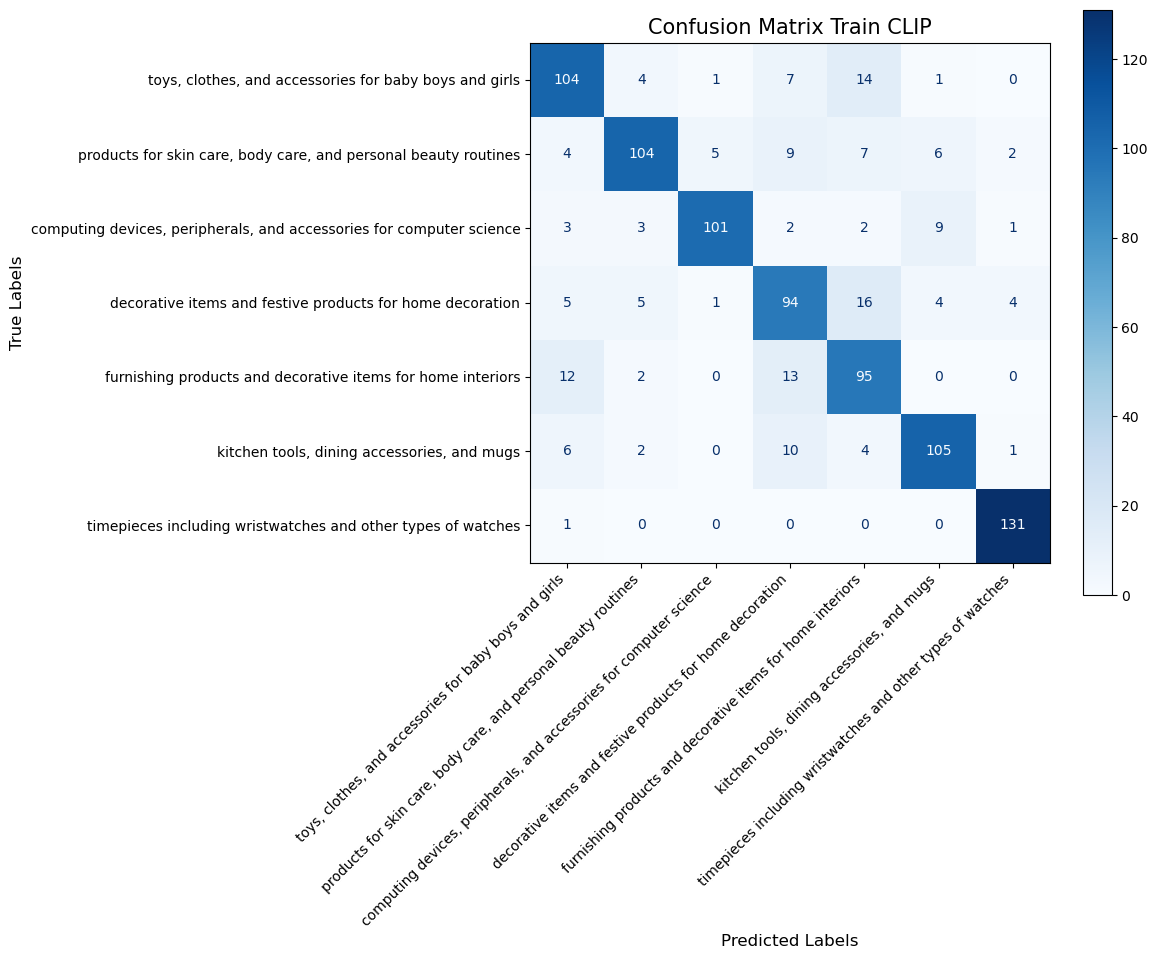

In [161]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matrice de confusion
true_labels_train = [list_classes.index(text) for text in texts_train]
conf_matrix_train = confusion_matrix(true_labels_train, preds_train)

fig, ax = plt.subplots(figsize=(12, 10)) 
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=list_classes)
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix Train CLIP', fontsize=15)
plt.tight_layout() 
plt.show()

In [162]:
from sklearn.metrics import precision_recall_fscore_support

# Calcul des métriques pour l'ensemble d'entraînement
precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(true_labels_train, preds_train, average='weighted')
print(f'Train Precision: {precision_train:.4f}')
print(f'Train Recall: {recall_train:.4f}')
print(f'Train F1-score: {f1_train:.4f}')

Train Precision: 0.8206
Train Recall: 0.8156
Train F1-score: 0.8166


## 4.2 - Test 

In [163]:
original_images_test = []
texts_test = []

for i, filename in enumerate(X_test['path_image']):
    image_path = os.path.join(data_path, filename)
    image = Image.open(image_path).convert("RGB")
    original_images_test.append(image)
    texts_test.append(descriptions[X_test.iloc[i]['main_category']])

In [164]:
# Prétraitement des images test
inputs_test = processor(images=original_images_test, return_tensors="pt")
image_test = inputs_test['pixel_values']

In [165]:
# Obtenir les embeddings d'image test
with torch.no_grad():
    img_emb_test = model.get_image_features(image_test)
    img_emb_test = img_emb_test / np.linalg.norm(img_emb_test, axis=1, keepdims=True)

In [166]:
# Évaluation sur l'ensemble test
with torch.no_grad():
    scores_test = np.dot(img_emb_test, label_emb.T)
    preds_test = np.argmax(scores_test, axis=1)

In [167]:
# Calcul de l'exactitude sur l'ensemble test
true_preds_test = [1 if list_classes[pred] == texts_test[i] else 0 for i, pred in enumerate(preds_test)]
accuracy_test = sum(true_preds_test) / len(true_preds_test)
print("Test Accuracy: {:.4f}".format(accuracy_test))

Test Accuracy: 0.7600


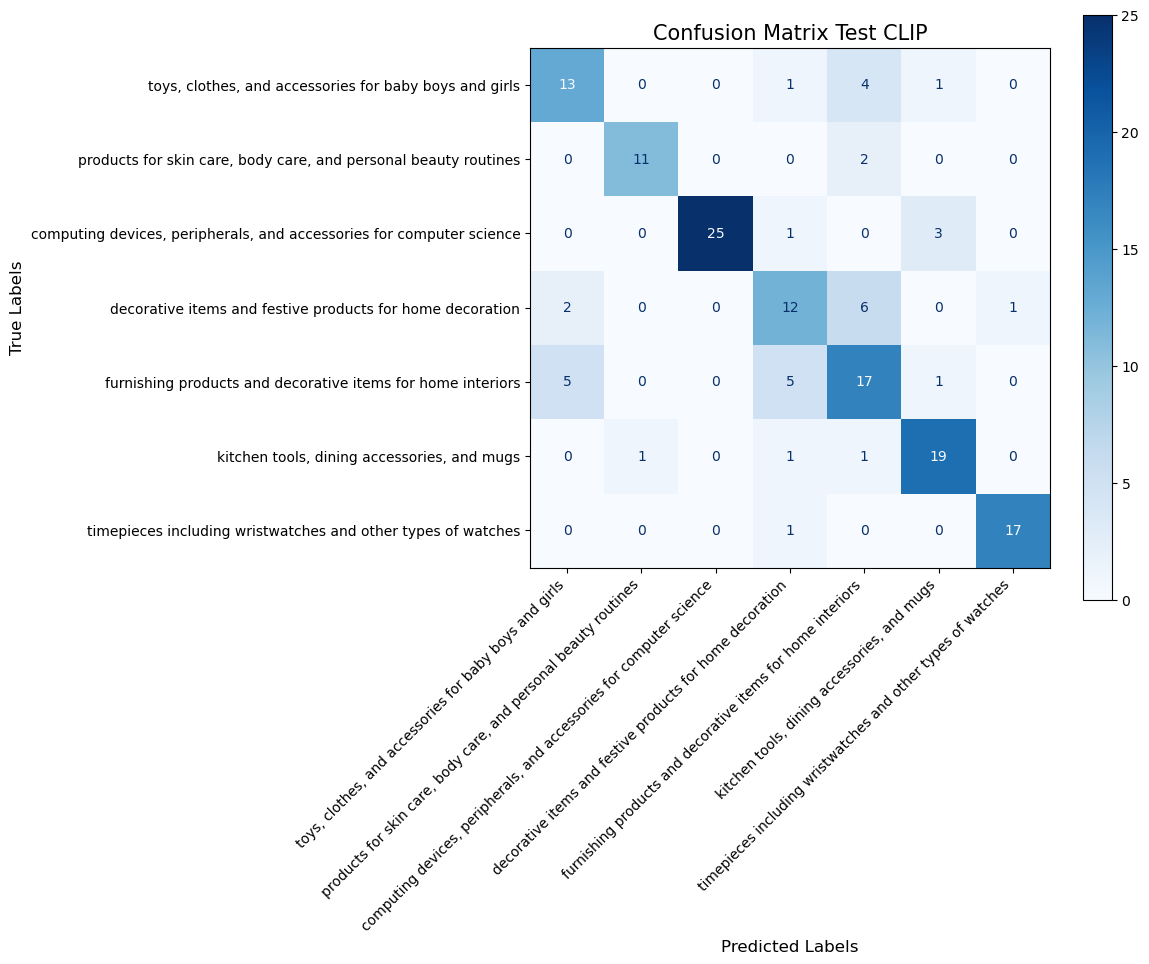

In [168]:
# Générer et afficher la matrice de confusion
true_labels_test = [list_classes.index(text) for text in texts_test]
conf_matrix_test = confusion_matrix(true_labels_test, preds_test)

# Afficher la matrice de confusion
fig, ax = plt.subplots(figsize=(12, 10))  
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=list_classes)
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix Test CLIP', fontsize=15)
plt.tight_layout() 
plt.show()

In [169]:
# Calcul des métriques pour l'ensemble de test
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(true_labels_test, preds_test, average='weighted')
print(f'Test Precision: {precision_test:.4f}')
print(f'Test Recall: {recall_test:.4f}')
print(f'Test F1-score: {f1_test:.4f}')

Test Precision: 0.7703
Test Recall: 0.7600
Test F1-score: 0.7636


## 4.3 Feature importance

In [170]:
# Vérifier la plage des scores
print(f"Plage des scores de similarité : Min={np.min(scores_test)}, Max={np.max(scores_test)}")


Plage des scores de similarité : Min=0.1330481320619583, Max=0.3153465688228607


In [171]:
# Feature importance globale pour l'ensemble de test
class_scores_test = []
for i in range(len(list_classes)):
    class_indices = np.where(np.array(true_labels_test) == i)[0]
    class_scores = scores_test[class_indices, i]
    class_scores_test.append(np.mean(class_scores))

for i, class_name in enumerate(list_classes):
    print(f"Classe : {class_name}, Score moyen : {class_scores_test[i]}")


Classe : toys, clothes, and accessories for baby boys and girls, Score moyen : 0.2610509991645813
Classe : products for skin care, body care, and personal beauty routines, Score moyen : 0.23423995077610016
Classe : computing devices, peripherals, and accessories for computer science, Score moyen : 0.24053122103214264
Classe : decorative items and festive products for home decoration, Score moyen : 0.2508518695831299
Classe : furnishing products and decorative items for home interiors, Score moyen : 0.26195669174194336
Classe : kitchen tools, dining accessories, and mugs, Score moyen : 0.2521899342536926
Classe : timepieces including wristwatches and other types of watches, Score moyen : 0.27515164017677307


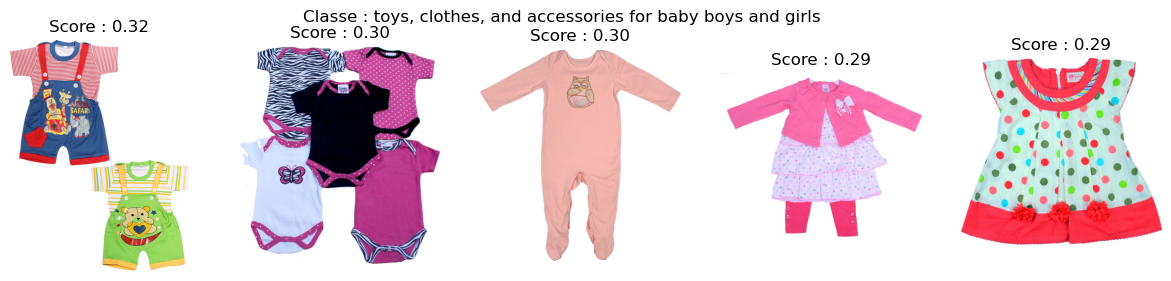

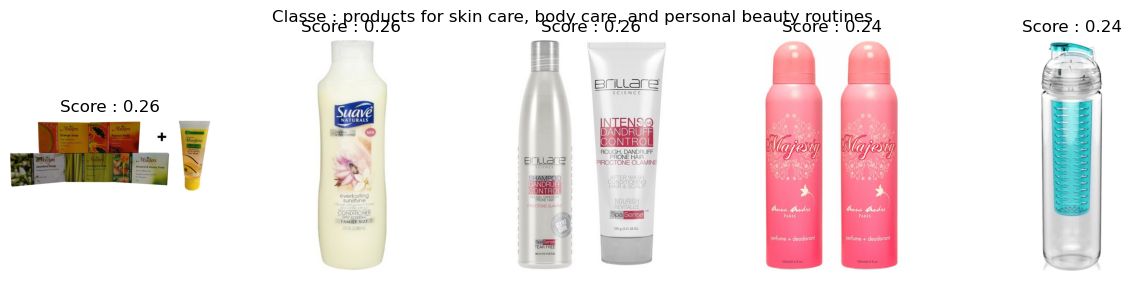

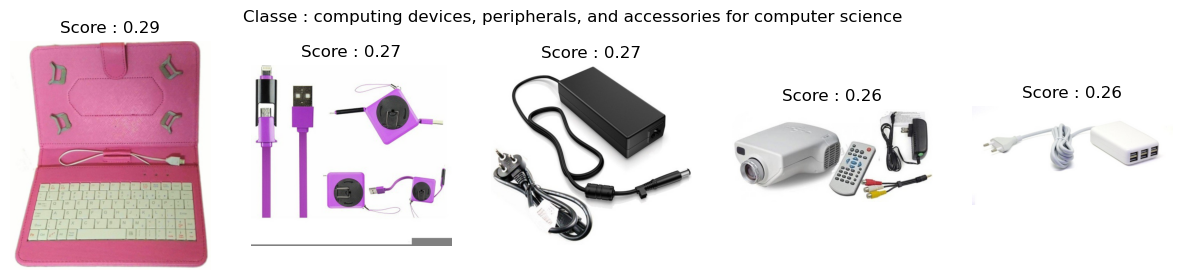

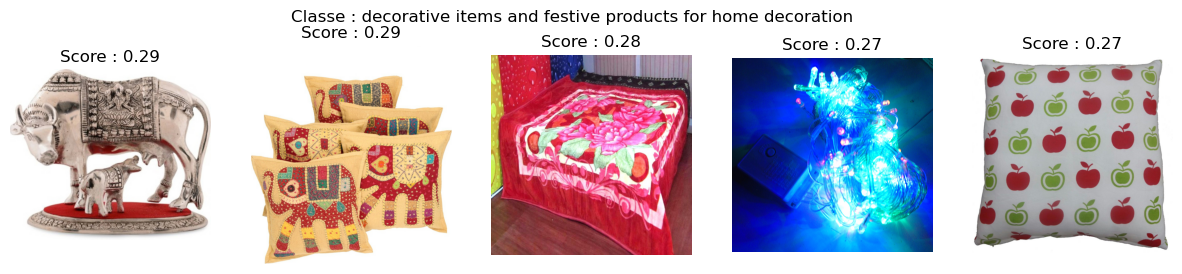

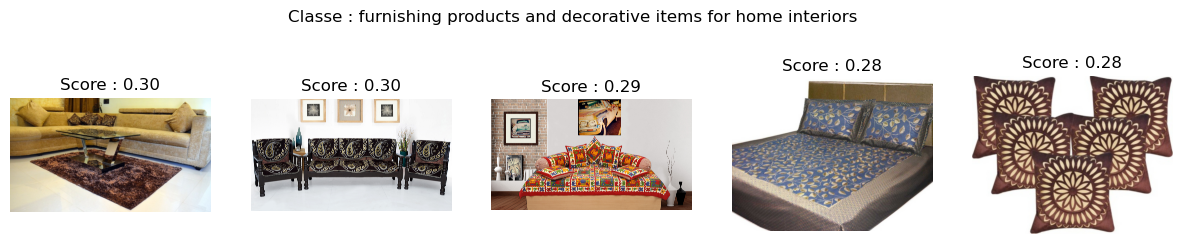

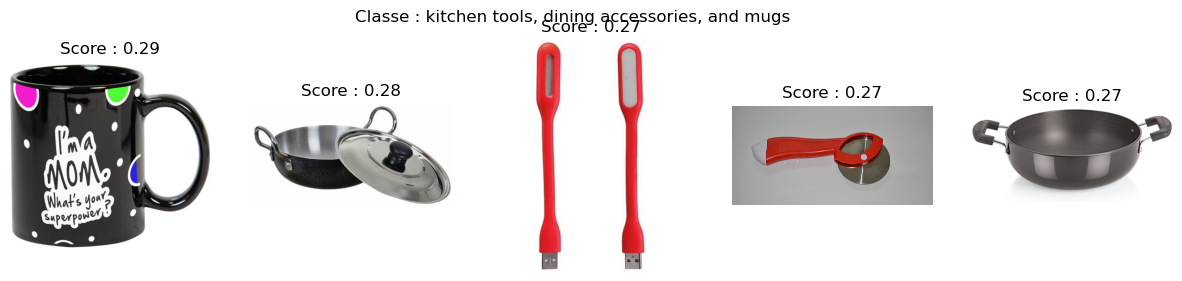

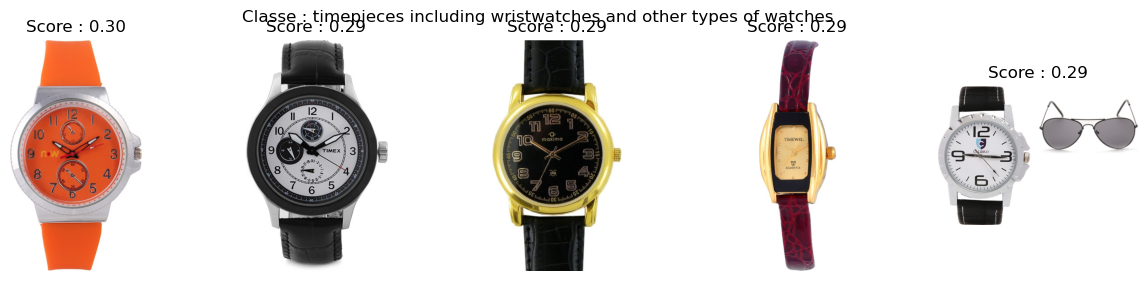

In [172]:
# Analyse de la feature importance locale pour l'ensemble de test (top images par classe)
top_indices = []
for i in range(len(list_classes)):
    class_indices = np.where(np.array(preds_test) == i)[0]
    top_indices.append(class_indices[np.argsort(scores_test[class_indices, i])[::-1][:5]])

# Afficher les images avec les scores de similarité les plus élevés pour chaque classe
for i, indices in enumerate(top_indices):
    plt.figure(figsize=(15, 3))
    for j, idx in enumerate(indices):
        plt.subplot(1, 5, j + 1)
        plt.imshow(original_images_test[idx])
        plt.title(f"Score : {scores_test[idx, i]:.2f}")
        plt.axis('off')
    plt.suptitle(f"Classe : {list_classes[i]}")
    plt.show()